In [1]:
import xarray as xr
import numpy as np
import gsw
import glob
import cosima_cookbook as cc

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41573,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:45079,Total threads: 4
Dashboard: /proxy/46023/status,Memory: 45.00 GiB
Nanny: tcp://127.0.0.1:37031,


### Control

In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
control_session = cc.database.create_session(session_name)

control = '01deg_jra55v13_ryf9091_DSW'

### Perturbations
GPC023 (Basal with Gade, No ICB) `01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb` : Tbasal based on Gade line, calving flux inserted at the surface as runoff

GPC026 (Basal with Gade, Yes ICB with gade) `01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb` : Tbasal based on Gade line and Merino distributed Iceberg Calving Flux on Gade line

GPC029 (Basal No Gade, No ICB) `01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb` : Tbasal equal Tinsitu, calving flux inserted at the surface as runoff

`session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'`

In [4]:
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

BasalGade_NoIcb = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'  # GPC023
BasalGade_YesIcb = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'  # GPC026
BasalNoGade_NoIcb = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'  # GPC029   

First create a mask for the continental shelf.  

In [5]:
def shelf_mask_isobath(var,isobath):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load(f'/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_{isobath}m.npz')
    var = var.sel(yt_ocean = slice(-90, -59.03))
    
    shelf_mask = contour_file['contour_masked_above'][26:-1, :]
    yt_ocean = contour_file['yt_ocean'][26:-1]
    xt_ocean = contour_file['xt_ocean']

    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map


temp = cc.querying.getvar(control, 'temp', control_session, frequency='1 monthly',start_time='1909-01-01', end_time='1909-02-01')
mask_1000, _ = shelf_mask_isobath(temp.isel(time=0, st_ocean=0), 1000)
mask_1000 = mask_1000.where(np.isnan(mask_1000), 1.)
#mask_1000.plot(figsize=(5,3)); plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Now we define a function to read in temperature and salinity data points for the region of interest. We will interpolate these points onto an even 50m vertical grid so as to prevent surface biasing the T-S diagrams. 

In [6]:
def read_and_convert_TS(expt, session, lon_slice, start_time, end_time, mask):
    '''
    Reads T and S from desired experiment (expt)
    Restricts to shelf and region given by lon_slice and lat_slice (below) and mask
    Convert TS using gsw
    '''

    print(expt)
    lat_slice = slice(-80, -60)
    z_slice = slice(0,2000)
    
    temp = cc.querying.getvar(expt, 'temp', session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    salt = cc.querying.getvar(expt, 'salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=z_slice).sel(time=slice(start_time, end_time))
    salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=z_slice).sel(time=slice(start_time, end_time))
    mask = mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    # convert salt to absolute salinity
    p = gsw.conversions.p_from_z(-temp.st_ocean, temp.yt_ocean)
    SA = gsw.conversions.SA_from_SP(salt, p, salt.xt_ocean,  salt.yt_ocean)
    
    # restrict T-S to shelf using mask
    temp = temp*mask
    salt = SA*mask

    # linearly interpolate to evenly spaced 50 m vertical grid and load data
    z_even = np.arange(1,2051,50)
    salt = salt.interp(st_ocean = z_even).load()
    temp = temp.interp(st_ocean = z_even).load()

    return temp.mean('time'), salt.mean('time')

Now define the plotting fucntions

In [7]:
ht = cc.querying.getvar(control, 'ht', control_session, n=-1)

def colorbar_vert(cb, axes, label):
    fs = 12
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax=cbaxes, orientation='vertical', extend = 'max')
    cbar.set_label(label,fontsize=fs+2,labelpad=2)
    cbar.ax.tick_params(labelsize=fs)
    return cbar

def colorbar_horz(cb, axes, label):
    fs = 10
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'max')
    cbar.set_label(label,fontsize=fs+2,labelpad=2)
    cbar.ax.tick_params(labelsize=fs)
    return cbar

def create_colour_array_model(salt):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth[i,:,:] = depth.st_ocean[i]        
    return depth

def create_colour_array_woa(salt):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(len(depth.depth)):
        depth[i,:,:] = depth.depth[i]        
    return depth

Set the region on interest. We'll just use the last year for now. 

In [8]:
start_time = '1909-01-02'
end_time = '1909-12-30'

# region = 'Weddell'
# lon_slice = slice(-62, -10)
# lat_range = [-78.5, -61]
# lat_range_labels = np.arange(-78, -59, 4)
# temp_range = [-2.5, 2]
# lon_range = [-62, -10]

# region = 'Amery'
# lon_slice = slice(55, 80)
# lat_range = [-70, -64]
# lat_range_labels = np.arange(-70, -63, 1)
# temp_range = [-2.5, 1]
# lon_range = [55, 80]

# region = 'Ross'
# lon_slice = slice(-200, -150)
# lat_range = [-78.7, -70]
# lat_range_labels = np.arange(-78, -69, 2)
# temp_range = [-2.5, 2]
# lon_range = [-200, -150]

# region = 'Amundsen'
# lon_slice = slice(-130, -100)
# lat_range = [-75.5, -70]
# lat_range_labels = np.arange(-75, -69, 1)
# temp_range = [-2.5, 2]
# lon_range = [-130, -100]

region = 'PanAntarctic'
lon_slice = slice(-280, 80)
lat_range = [-79.5, -60]
lat_range_labels = np.arange(-78, -59, 2)
temp_range = [-2.5, 2]

And read in data for T-S figure. 

In [12]:
%%time
temp_ctrl, salt_ctrl = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_NoIcb, salt_Gade_NoIcb = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_YesIcb, salt_Gade_YesIcb = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
# temp_NoGade_NoIcb, salt_NoGade_NoIcb = read_and_convert_TS(BasalNoGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)

01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
CPU times: user 15.6 s, sys: 5.07 s, total: 20.6 s
Wall time: 24.4 s


Load WOA18 observations. These are in situ temperature and (I think) practical salinity, so unit conversions are required.

In [10]:
%%time
woa_dir = '/g/data/e14/hd4873/obs_data/woa/woa18/'
woa_temp = xr.open_dataset(woa_dir+'woa18_decav_t00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['t_an']
woa_salt = xr.open_dataset(woa_dir+'woa18_decav_s00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['s_an']
woa_temp

# replace temp and salt land values with np.nan
woa_temp = woa_temp.where(woa_temp < 1000, np.nan)
woa_salt = woa_salt.where(woa_salt < 1000, np.nan)

# Unit conversions
# Absolute salinity from practical salinity
p = gsw.p_from_z(-woa_salt.depth, woa_salt.lat)
woa_salt = gsw.conversions.SA_from_SP(woa_salt, p, woa_salt.lon, woa_salt.lat)
# Calculate potential temp from in insitu temp using surface reference pressure
p_ref = 0.
woa_temp = gsw.pt_from_t(woa_salt, woa_temp, p, p_ref)
# Calcualte conservative temperature from potential temperature
woa_temp = gsw.CT_from_pt(woa_salt, woa_temp)

# concat observations onto model grid.
x = woa_temp.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
woa_temp['lon'] = x
woa_salt['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
woa_temp = xr.concat((woa_temp[:,:,260:], woa_temp[:,:,:260]), dim='lon')
woa_salt = xr.concat((woa_salt[:,:,260:], woa_salt[:,:,:260]), dim='lon')

# interpolat ehself mask onto woa obs
mask_woa = mask_1000.interp(yt_ocean=woa_temp.lat,xt_ocean=woa_temp.lon)
# restrict woa obs to shelf
woa_temp = (woa_temp*mask_woa).load()
woa_salt = (woa_salt*mask_woa).load()


CPU times: user 4.33 s, sys: 1.16 s, total: 5.49 s
Wall time: 7.04 s


Create density mesh for T-S figures. 

In [13]:
temp_bins = np.arange(np.floor(temp_ctrl.min().values)-1, np.ceil(temp_ctrl.max().values+2), 0.5)
salt_bins = np.arange(np.floor(salt_ctrl.min().values), np.ceil(salt_ctrl.max().values+0.5), 0.1)
# for density contours in TS diagram
temp_bins_mesh,salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
TS_density = gsw.density.sigma0(salt_bins_mesh, temp_bins_mesh)

# create depth array for colouring
depth_ctrl = create_colour_array_model(salt_ctrl)
depth_Gade_NoIcb = create_colour_array_model(salt_Gade_NoIcb)
depth_Gade_YesIcb = create_colour_array_model(salt_Gade_YesIcb)
depth_woa = create_colour_array_woa(woa_salt)

Define figure functions figure.

In [12]:
def T_S_figure():
    labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']
    expt_labels = ['    OBS', '    CONTROL', r'    $BASAL_{Gade}$',r'    $BASAL_{Gade}+ICB$', r'    $BASAL_{NoGade}$']
    
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(1,4, figsize=(20,4.6), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    axes[0].set_ylabel('Conservative temperature (\u00b0C)', fontsize=14)
    axes[0].set_ylim(temp_range)
    axes[0].set_yticks(np.arange(-2,2.1,1))
    axes[0].set_xlim([33,35.2])
    

    for i, ax in enumerate(axes.flatten()):

        ax.text(0.04, 0.9, expt_labels[i], ha='left', fontsize=16, transform=ax.transAxes,
               bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        ax.text(0.04, 0.9, f'{labels[i]}',fontsize=16,fontweight='bold',transform=ax.transAxes, 
               #bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2')
               )
        ax.set_xlabel('Absolute salinity (g/kg)', fontsize=14)

        # contour density
        contour_levels = np.arange(26, 29, 0.2)
        cs= ax.contour(salt_bins_mesh, temp_bins_mesh, TS_density, colors='grey',linewidths=0.5,
                       levels=contour_levels)
        ax.clabel(cs, contour_levels, fontsize=10)
        
        # Add freezing line
        salt_arr = np.arange(27, 37, 0.1)
        tfreeze_arr = gsw.CT_freezing(salt_arr, 1, 0.1)
        ax.plot(salt_arr, tfreeze_arr, 'dimgrey', lw=1, ls='--', zorder=1)

    return fig, axes

## Circum-Antarctic T-S plot

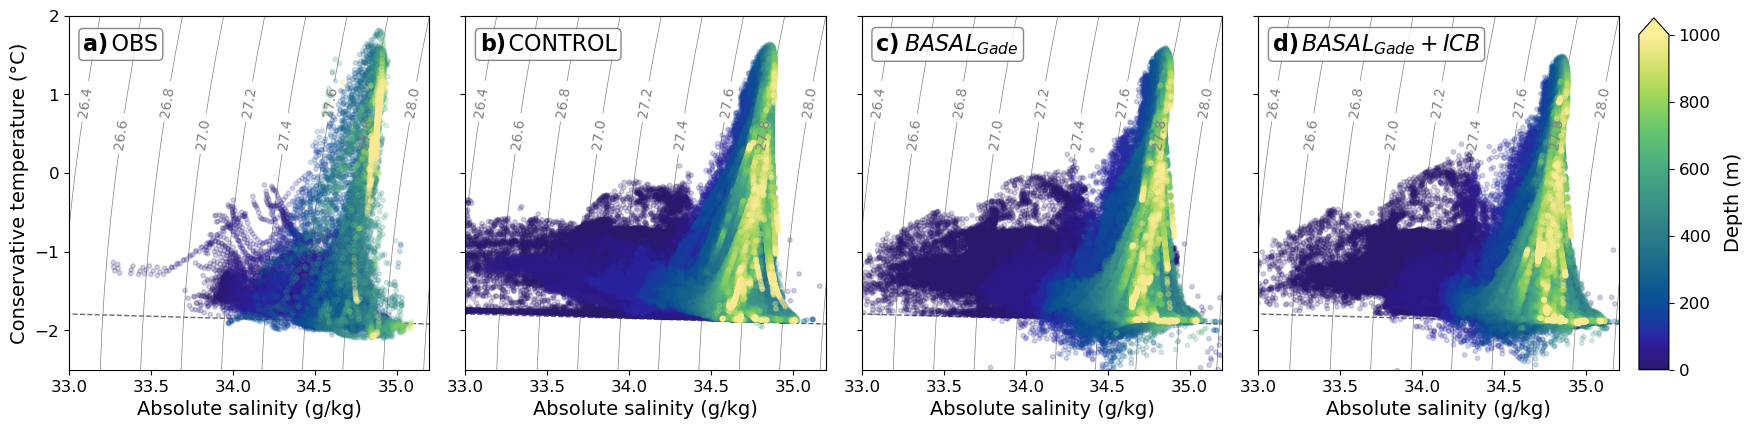

CPU times: user 5min 12s, sys: 34.1 s, total: 5min 46s
Wall time: 4min 53s


In [13]:
%%time
vminD, vmaxD, s = 0, 1000, 10

# create figure
fig, axes = T_S_figure()

# # Add T-S diagrams
axes[0].scatter(woa_salt,woa_temp, c=depth_woa, cmap=cmocean.haline, 
                vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[1].scatter(salt_ctrl[:,::2,::2],temp_ctrl[:,::2,::2], c=depth_ctrl[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[2].scatter(salt_Gade_NoIcb[:,::2,::2],temp_Gade_NoIcb[:,::2,::2], c=depth_ctrl[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[3].scatter(salt_Gade_YesIcb[:,::2,::2],temp_Gade_YesIcb[:,::2,::2], c=depth_ctrl[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
# create dummy scatter for colorbar
cbTS = axes[0].scatter(0,1, c=500, cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=1, zorder=2)

# add colorbar
colorbar_vert(cbTS, [0.91, 0.11, 0.015, 0.765], 'Depth (m)')

fig.savefig('Figure05_T-S_diag_circumantarctic.jpg', bbox_inches='tight', dpi=300)

plt.show()

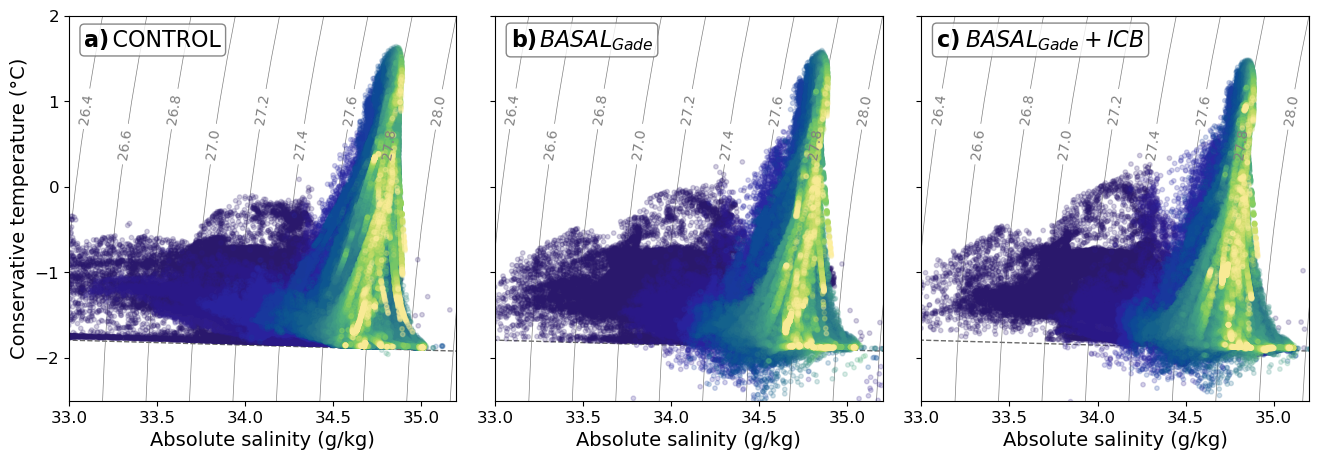

CPU times: user 2min 41s, sys: 18.6 s, total: 3min
Wall time: 2min 34s


In [69]:
%%time
vminD, vmaxD, s = 0, 1000, 10

# create figure
fig, axes = T_S_map_figure()

# Add T-S diagrams
axes[0].scatter(salt_ctrl[:,::2,::2],temp_ctrl[:,::2,::2], c=depth_ctrl[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[1].scatter(salt_Gade_NoIcb[:,::2,::2],temp_Gade_NoIcb[:,::2,::2], c=depth_Gade_NoIcb[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[2].scatter(salt_Gade_YesIcb[:,::2,::2],temp_Gade_YesIcb[:,::2,::2], c=depth_ctrl[:,::2,::2], 
                cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
# create dummy scatter for colorbar
cbTS = axes[0].scatter(0,1, c=500, cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=1, zorder=2)

plt.show()

## Regional T-S plots

In [8]:
def load_regional_woa(lon_slice, lat_slice):
    woa_dir = '/g/data/e14/hd4873/obs_data/woa/woa18/'
    woa_temp = xr.open_dataset(woa_dir+'woa18_decav_t00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['t_an']
    woa_salt = xr.open_dataset(woa_dir+'woa18_decav_s00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['s_an']
    woa_temp
    
    # replace temp and salt land values with np.nan
    woa_temp = woa_temp.where(woa_temp < 1000, np.nan)
    woa_salt = woa_salt.where(woa_salt < 1000, np.nan)
    
    # Unit conversions
    # Absolute salinity from practical salinity
    p = gsw.p_from_z(-woa_salt.depth, woa_salt.lat)
    woa_salt = gsw.conversions.SA_from_SP(woa_salt, p, woa_salt.lon, woa_salt.lat)
    # Calculate potential temp from in insitu temp using surface reference pressure
    p_ref = 0.
    woa_temp = gsw.pt_from_t(woa_salt, woa_temp, p, p_ref)
    # Calcualte conservative temperature from potential temperature
    woa_temp = gsw.CT_from_pt(woa_salt, woa_temp)
    
    # concat observations onto model grid.
    x = woa_temp.lon.values
    x[x> 80] = x[x>80]-360
    # replace lon coordinate values with these modified longitude values
    woa_temp['lon'] = x
    woa_salt['lon'] = x
    # now concatenate temp and salinity so that it goes from -280 to 80 like access
    woa_temp = xr.concat((woa_temp[:,:,260:], woa_temp[:,:,:260]), dim='lon')
    woa_salt = xr.concat((woa_salt[:,:,260:], woa_salt[:,:,:260]), dim='lon')
    
    # interpolate shelf mask onto woa obs
    mask_woa = mask_1000.interp(yt_ocean=woa_temp.lat,xt_ocean=woa_temp.lon)
    # restrict woa obs to shelf
    woa_temp = (woa_temp*mask_woa).load()
    woa_salt = (woa_salt*mask_woa).load()

    # select region
    woa_temp = woa_temp.sel(lat=lat_slice, lon=lon_slice)
    woa_salt = woa_salt.sel(lat=lat_slice, lon=lon_slice)
    
    return woa_temp, woa_salt


In [9]:
%%time
start_time = '1909-01-02'
end_time = '1909-12-30'

region = 'Weddell'
lon_slice = slice(-62, -10)
lat_range = [-78.5, -63.5]
temp_range = [-2.5, 2]
temp_ctrl_ws, salt_ctrl_ws = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_NoIcb_ws, salt_Gade_NoIcb_ws = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_YesIcb_ws, salt_Gade_YesIcb_ws = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
woa_temp_ws, woa_salt_ws = load_regional_woa(lon_slice, slice(lat_range[0], lat_range[1]))
depth_ctrl_ws = create_colour_array_model(salt_ctrl_ws)
depth_woa_ws = create_colour_array_woa(woa_salt_ws)
                                             
# region = 'Amery'
# lon_slice = slice(55, 80)
# lat_range = [-70, -64]
# lat_range_labels = np.arange(-70, -63, 1)
# temp_range = [-2.5, 1]
# lon_range = [55, 80]
# temp_ctrl_ais, salt_ctrl_ais = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
# temp_Gade_NoIcb_ws, salt_Gade_NoIcb_ais = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
# temp_Gade_YesIcb_ais, salt_Gade_YesIcb_ais = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
# woa_temp_ais, woa_salt_ais = load_regional_woa(lon_slice, slice(lat_range[0], lat_range[1]))

region = 'EastAntarctica'
lon_slice = slice(-260, -230)
lat_range = [-70, -64]
temp_range = [-2.5, 1]
temp_ctrl_ea, salt_ctrl_ea = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_NoIcb_ea, salt_Gade_NoIcb_ea = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_YesIcb_ea, salt_Gade_YesIcb_ea = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
woa_temp_ea, woa_salt_ea = load_regional_woa(lon_slice, slice(lat_range[0], lat_range[1]))
depth_ctrl_ea = create_colour_array_model(salt_ctrl_ea)
depth_woa_ea = create_colour_array_woa(woa_salt_ea)

region = 'Ross'
lon_slice = slice(-200, -150)
lat_range = [-78.7, -70]
lat_range_labels = np.arange(-78, -69, 2)
temp_range = [-2.5, 2]
lon_range = [-200, -150]
temp_ctrl_rs, salt_ctrl_rs = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_NoIcb_rs, salt_Gade_NoIcb_rs = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_YesIcb_rs, salt_Gade_YesIcb_rs = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
woa_temp_rs, woa_salt_rs = load_regional_woa(lon_slice, slice(lat_range[0], lat_range[1]))
depth_ctrl_rs = create_colour_array_model(salt_ctrl_rs)
depth_woa_rs = create_colour_array_woa(woa_salt_rs)

region = 'Amundsen'
lon_slice = slice(-130, -100)
lat_range = [-75.5, -70]
lat_range_labels = np.arange(-75, -69, 1)
temp_range = [-2.5, 2]
lon_range = [-130, -100]
temp_ctrl_as, salt_ctrl_as = read_and_convert_TS(control, control_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_NoIcb_as, salt_Gade_NoIcb_as = read_and_convert_TS(BasalGade_NoIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
temp_Gade_YesIcb_as, salt_Gade_YesIcb_as = read_and_convert_TS(BasalGade_YesIcb, basal_melt_session, lon_slice, start_time, end_time, mask_1000)
woa_temp_as, woa_salt_as = load_regional_woa(lon_slice, slice(lat_range[0], lat_range[1]))
depth_ctrl_as = create_colour_array_model(salt_ctrl_as)
depth_woa_as = create_colour_array_woa(woa_salt_as)

01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
CPU times: user 1min 43s, sys: 32.5 s, total: 2min 15s
Wall time: 3min


In [10]:
def T_S_regional_figure():
    labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)','p)','']
    expt_labels = ['    OBS', '    CONTROL', r'    $BASAL_{Gade}$',r'    $BASAL_{Gade}+ICB$',]
    regions = ['Weddell','East Antarctica','Ross','Amundsen']
    
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(4,4, figsize=(20,18), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    axes[0,0].set_ylabel('Conservative temperature (\u00b0C)', fontsize=14)
    axes[0,0].set_ylim(temp_range)
    axes[0,0].set_yticks(np.arange(-2,2.1,1))
    axes[0,0].set_xlim([33,35.2])

    for i, ax in enumerate(axes[-1,:].flatten()):
        ax.set_xlabel('Absolute salinity (g/kg)', fontsize=14)

    for i, ax in enumerate(axes[:,0].flatten()):
        ax.set_ylabel('Conservative \ntemperature (\u00b0C)', fontsize=14)
    

    for i, ax in enumerate(axes.flatten()):

        ax.text(0.04, 0.9, np.tile(expt_labels,4)[i], ha='left', fontsize=16, transform=ax.transAxes,
               bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        ax.text(0.04, 0.9, f'{labels[i]}',fontsize=16,fontweight='bold',transform=ax.transAxes, 
               #bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2')
               )
        ax.text(0.04, 0.05, np.repeat(regions,4)[i], ha='left', fontsize=16, c='k', fontweight='bold', transform=ax.transAxes,)
        
        #ax.set_xlabel('Absolute salinity (g/kg)', fontsize=14)

        # contour density
        contour_levels = np.arange(26, 29, 0.2)
        cs= ax.contour(salt_bins_mesh, temp_bins_mesh, TS_density, colors='grey',linewidths=0.5,
                       levels=contour_levels)
        ax.clabel(cs, contour_levels, fontsize=10)
        
        # Add freezing line
        salt_arr = np.arange(27, 37, 0.1)
        tfreeze_arr = gsw.CT_freezing(salt_arr, 1, 0.1)
        ax.plot(salt_arr, tfreeze_arr, 'dimgrey', lw=1, ls='--', zorder=1)

    return fig, axes

Plot regional figure. 

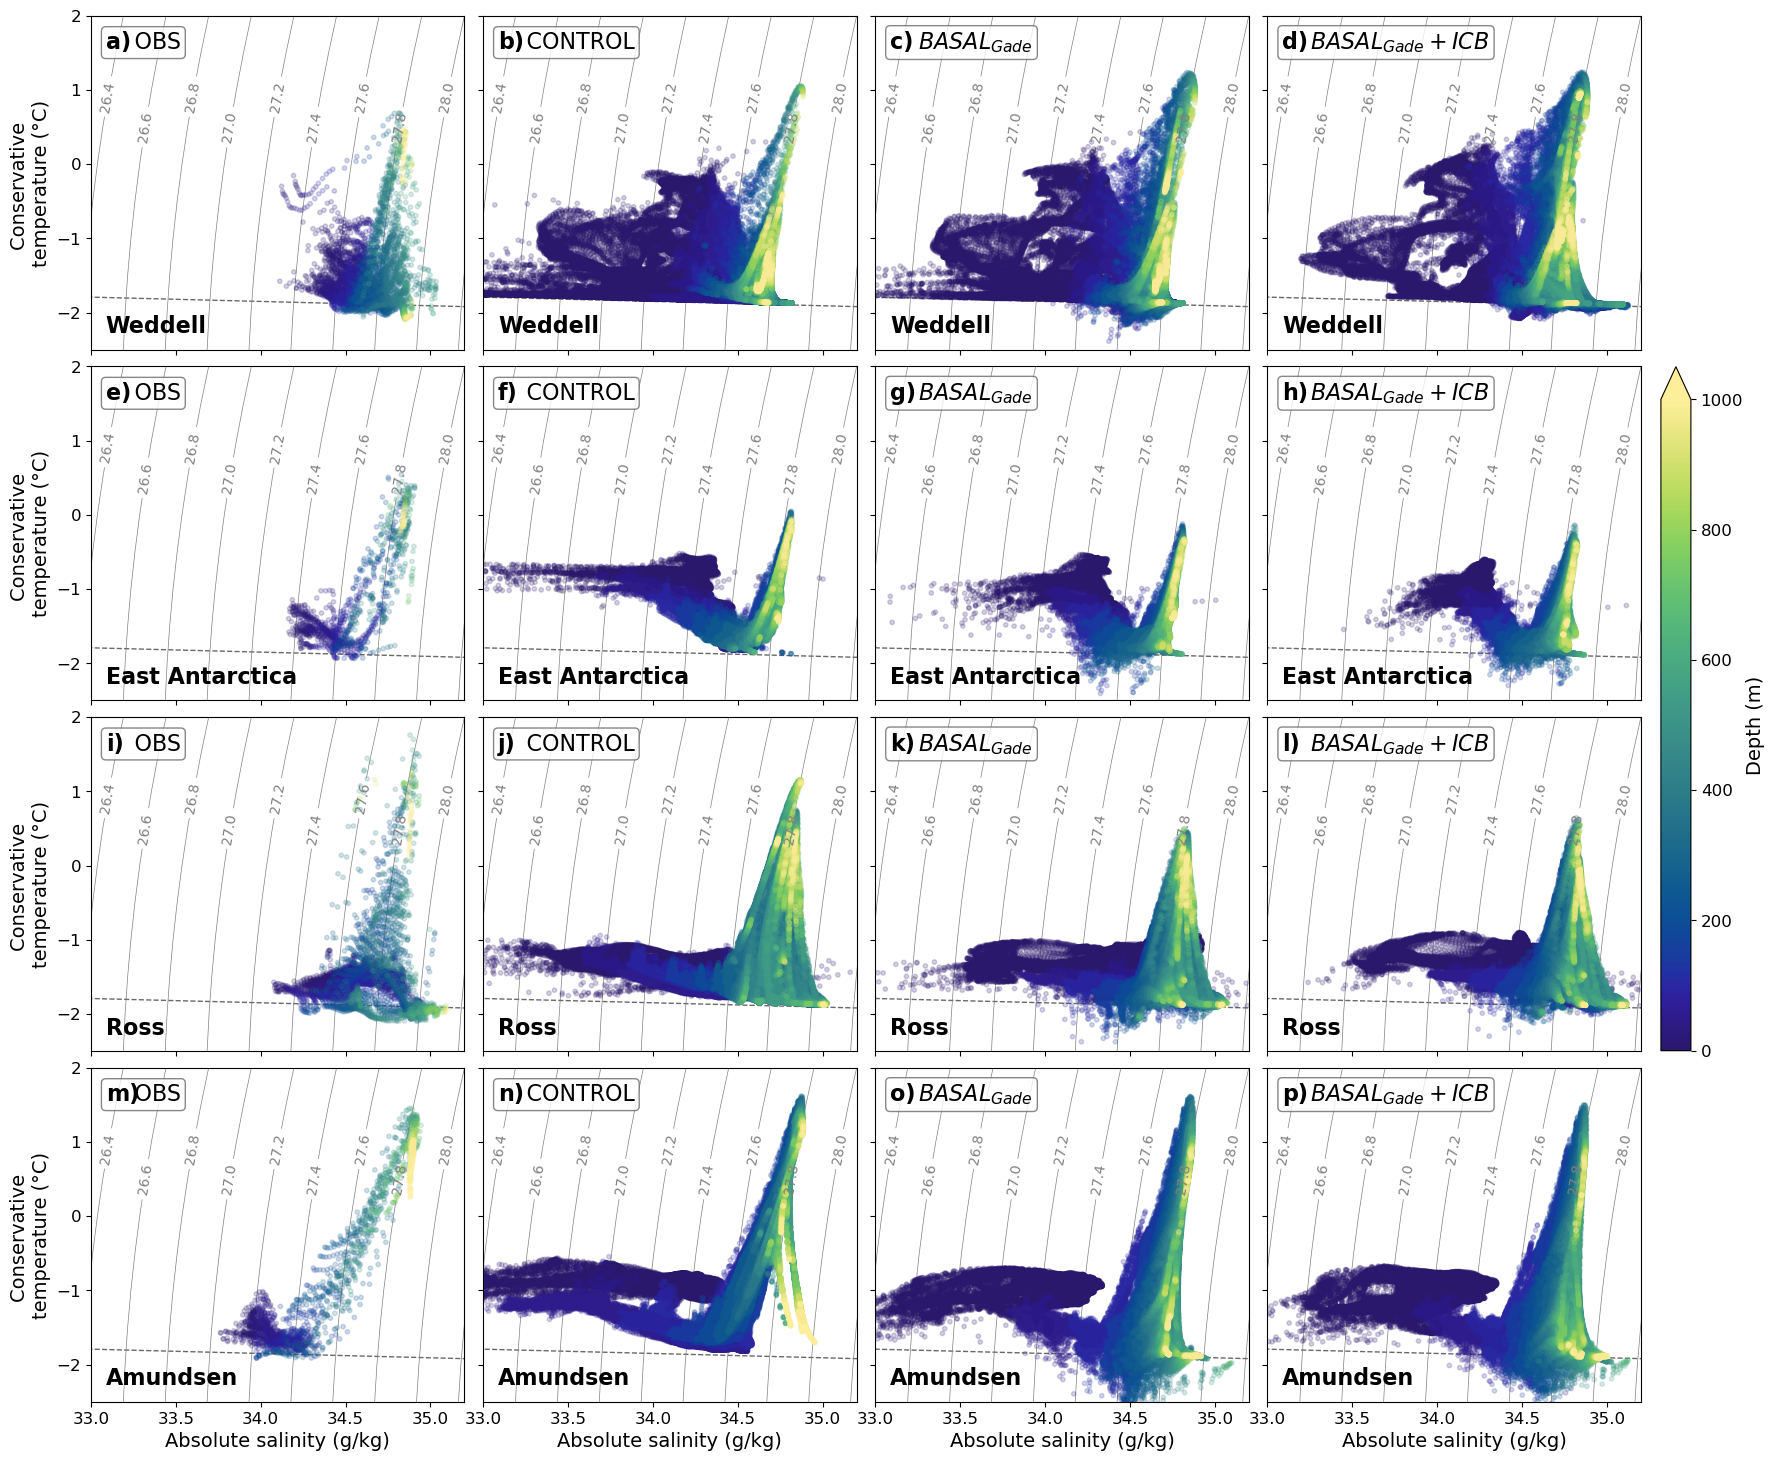

CPU times: user 10min 6s, sys: 41.9 s, total: 10min 48s
Wall time: 9min 39s


In [17]:
%%time
vminD, vmaxD, s = 0, 1000, 10

# create figure
fig, axes = T_S_regional_figure()


# Weddell
axes[0,0].scatter(woa_salt_ws, woa_temp_ws, c=depth_woa_ws, cmap=cmocean.haline, 
                  vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[0,1].scatter(salt_ctrl_ws,temp_ctrl_ws, c=depth_ctrl_ws, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[0,2].scatter(salt_Gade_NoIcb_ws,temp_Gade_NoIcb_ws, c=depth_ctrl_ws, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[0,3].scatter(salt_Gade_YesIcb_ws,temp_Gade_YesIcb_ws, c=depth_ctrl_ws, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')

# East Antarctica
axes[1,0].scatter(woa_salt_ea, woa_temp_ea, c=depth_woa_ea, cmap=cmocean.haline, 
                  vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[1,1].scatter(salt_ctrl_ea,temp_ctrl_ea, c=depth_ctrl_ea, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[1,2].scatter(salt_Gade_NoIcb_ea,temp_Gade_NoIcb_ea, c=depth_ctrl_ea, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[1,3].scatter(salt_Gade_YesIcb_ea,temp_Gade_YesIcb_ea, c=depth_ctrl_ea, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')

# Ross
axes[2,0].scatter(woa_salt_rs, woa_temp_rs, c=depth_woa_rs, cmap=cmocean.haline, 
                  vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[2,1].scatter(salt_ctrl_rs,temp_ctrl_rs, c=depth_ctrl_rs, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[2,2].scatter(salt_Gade_NoIcb_rs,temp_Gade_NoIcb_rs, c=depth_ctrl_rs, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[2,3].scatter(salt_Gade_YesIcb_rs,temp_Gade_YesIcb_rs, c=depth_ctrl_rs, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')

# Amundsen
axes[3,0].scatter(woa_salt_as, woa_temp_as, c=depth_woa_as, cmap=cmocean.haline, 
                  vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[3,1].scatter(salt_ctrl_as,temp_ctrl_as, c=depth_ctrl_as, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[3,2].scatter(salt_Gade_NoIcb_as,temp_Gade_NoIcb_as, c=depth_ctrl_as, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')
axes[3,3].scatter(salt_Gade_YesIcb_as,temp_Gade_YesIcb_as, c=depth_ctrl_as, 
                  cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=0.2, zorder=2, facecolors='none')

# create dummy scatter for colorbar
cbTS = axes[0,0].scatter(0,1, c=500, cmap=cmocean.haline, vmin=vminD, vmax=vmaxD, s=s, alpha=1, zorder=2)
# add colorbar
colorbar_vert(cbTS, [0.91, 0.305, 0.015, 0.38], 'Depth (m)')

fig.savefig('Figure05_T-S_diag_regional.jpg', bbox_inches='tight', dpi=300)

plt.show()